# 2021 QTA Project —— Asset Allocation

*Author: 陈逸杰，李亚芬，金希，吴宜邹*

## Content

- [Part I: 数据准备](#Part-I:-数据准备)  
- [Part II: Risk Parity 模型](#Part-II:-Risk-Parity-模型)
- [Part III: Risk Budget 模型](#Part-III:-Risk-Budget-模型)  
- [Part IV: MVO 模型](#Part-IV:-MVO-模型)
- [Part V: Black-Litterman 模型](#Part-V:-Black-Litterman-模型) 
- [Part VI: 回测函数实现](#Part-VI:-回测函数实现)
- [Part VII: 回测结果](#Part-VII:-回测结果)

In [38]:
import pandas as pd
import numpy as np
import cvxpy as cp
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from scipy.optimize import NonlinearConstraint

# Part I: 数据准备

数据构成：全球指数数据 

数据日期：2011-04-18：2021-10-01

$$\text{Table 1. 指数列表}$$

指数名称 | 指数代码 | 数据来源
-|:- | -:
上证综指|000001.SZ|WIND
恒生指数|HSI|Bloomberg
标普500|SPX|Bloomberg
日经225|NKY|Bloomberg
富时100|UKX|Bloomberg
德国DAX|DAX|Bloomberg
中国10年期国债|SBCNL|Bloomberg	
英国10年期国债|SGIXBGB|Bloomberg	
德国10年期国债|SGIXBRX|Bloomberg
日本10年期国债|SGIXBJB|Bloomberg
美国10年期国债|SGIXBTY|Bloomberg
美元指数|BBDXY|Bloomberg
彭博贵金属指数|BCOMPR|Bloomberg
彭博工业金属指数|BCOMINSP|Bloomberg
彭博能源子指数|BCOMEN|Bloomberg
彭博大宗商品指数|BCOM|Bloomberg

## 读取指数数据

In [39]:
index_assets=[]

In [40]:
index_asset_name_list=['DAX','SBCNL','HSI','NKY','BGB','BRX','BJB','BTY','SPX','UKX','BBDXY','BCOMPR','BCOMINSP','BCOMEN','BCOM']

In [41]:
for asset_name in index_asset_name_list:
    
    #第一次时使用
    #data = pd.read_excel('data/'+asset_name+'.xlsx',sheet_name=0,index_col=0)
    #data.to_csv('data/'+asset_name+'.csv',encoding='utf-8')
    df = pd.read_csv('data/'+asset_name+'.csv',header=6)
    
    df=df.iloc[:,:2]
    df["Date"]= pd.to_datetime(df['Date'],errors='coerce')
    df=df[df['Date']<'2021-10-01']
    df=df[df['Date']>='2011-04-18']
    df=df.rename(columns={'Date':'date','PX_LAST':asset_name})
    df=df.sort_index(ascending=False)
    index_assets.append(df)

## 计算指数收益率

In [42]:
index_assets_pcts=[]
for i in range(len(index_assets)):
    daily_pct_change = (index_assets[i][index_asset_name_list[i]] / index_assets[i][index_asset_name_list[i]].shift(1) - 1)*100
    #daily_pct_change = assets[i].pct_change()
    daily_pct_change.fillna(0, inplace=True)
    #print(daily_pct_change)
    df_pct=pd.DataFrame({"date":index_assets[i]["date"],index_asset_name_list[i]:daily_pct_change})
    index_assets_pcts.append(df_pct)


In [43]:
#读入上证综指指数收益率
df_sz = pd.read_csv('data/sh000001.csv')
df_sz['date']=pd.to_datetime(df_sz['date'],errors='coerce')
df_sz=df_sz[df_sz['date']<'2021-10-01']
df_sz=df_sz[df_sz['date']>='2011-04-18']

## 合并指数收益率

In [44]:
df_pct_table=df_sz
for i in range(len(index_assets)):
    df_pct_table=df_pct_table.merge(index_assets_pcts[i],how='outer',on="date")
    df_pct_table.fillna(0, inplace=True)

df_pct_table=df_pct_table.set_index(['date'])
df_pct_table=df_pct_table.sort_index(ascending=True)
df_pct_table

,SZ,DAX,SBCNL,HSI,NKY,BGB,BRX,BJB,BTY,SPX,UKX,BBDXY,BCOMPR,BCOMINSP,BCOMEN,BCOM
date,,,,,,,,,,,,,,,,
2011-04-18,0.2230,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2011-04-19,-1.9065,0.719085,-0.018479,-1.314791,-1.233807,0.373770,0.310855,0.104871,0.052076,0.573119,0.883014,-0.449484,0.762426,0.684204,0.926342,0.578548
2011-04-20,0.2666,4.283649,0.092410,1.687903,1.743711,0.409113,1.073729,-0.012157,-0.286246,1.351495,2.639643,-0.787746,0.556948,1.980691,2.116901,1.116834
2011-04-21,0.6528,1.159381,0.505850,1.053909,1.647921,1.278175,0.822417,0.848280,0.065236,0.528428,0.836200,-0.347510,1.326156,1.018519,1.051625,0.872378
2011-04-22,-0.5336,0.000000,-0.339661,0.000000,-0.231977,0.000000,0.000000,-0.073718,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-09-24,-0.8004,-0.954046,-0.128528,-1.313401,0.996356,-1.025327,-0.733661,-1.178523,-0.341839,0.146101,-0.850712,0.258923,-0.152951,0.293019,1.645212,0.755431
2021-09-27,-0.8369,0.151432,0.153270,0.099559,-0.254087,-0.051854,-0.301215,-0.235102,-0.230647,-0.277636,0.359422,0.012999,0.266374,-1.084685,4.644176,1.866790
2021-09-28,0.5411,-2.256223,-0.094283,1.190261,-0.561768,-1.628906,-0.338300,-0.491983,-0.254883,-2.036411,-1.777451,0.509510,-0.864352,0.100208,0.626139,0.090255


In [45]:
assets=list(df_pct_table.columns)
print(assets)
print(len(assets))

['SZ', 'DAX', 'SBCNL', 'HSI', 'NKY', 'BGB', 'BRX', 'BJB', 'BTY', 'SPX', 'UKX', 'BBDXY', 'BCOMPR', 'BCOMINSP', 'BCOMEN', 'BCOM']
16


In [46]:
df_pct_table.to_csv('data/pct_table.csv', index=True, header=True )

# 生成再平衡日期

每5天 再平衡1次，共需469次
第1个回测开始日期 2012-10-01  索引 380
第n个回测开始索引 380+(n-1)*380
训练开始时间往前

In [47]:
N=469
adjust_date_list_for_test=[]
#train_start_index_list=[]
train_end_index_list=[]
for i in range(N):
    end_index=380 + i*5 

    train_end_index_list.append(end_index)
    adjust_date_list_for_test.append(df_pct_table.index[end_index])
    

In [48]:
len(train_end_index_list)

469

In [49]:
#model_name: risk_pairty  risk_budget  mvo
def made_input_for_test(adjust_date_list_for_test,weight_list,model_name):
    weight_for_test_df=pd.DataFrame(weight_list)
    weight_for_test_df['date'] = adjust_date_list_for_test
    weight_for_test_df = weight_for_test_df.set_index('date')
    weight_for_test_df.to_csv('data/'+model_name+'_weight_for_test.csv', index=True, header=True )

# Part II: Risk Parity 模型

假定组合包含$n$个资产，权重为$x=(x_{1},x_{2},...,x_{n}) ^{'} $, 由此确定的组合风险记为$R(x)$

采用收益率的标准差来度量组合风险，即:
\begin{align*}R(x)= \sqrt{x^{'}\Sigma x }\end{align*}

第${i}$个资产的边际风险贡献:
\begin{align*}MCR_{i} = \frac{\partial R(x)}{\partial x_{i}}=   \frac{(\sum\limits x)_{i}}{ R (x)} \end{align*}
第${i}$个资产的风险贡献：
\begin{align*}RC_{i}=x_{i} \cdot \frac{(\sum\limits x)_{i}}{R(x)}\end{align*}

欧拉配置原则：
\begin{align*}R(x)= \sum\limits_{i=1}^nRC_i \end{align*}

风险平价（RP）策略的理念是：找到一个风险平衡的投资组合，使投资组合的所有资产的风险贡献相同。投资组合x是一个RP投资组合，当且仅当它满足条件:
\begin{align*}RC_{i}=RC{j},for \forall i \neq j\end{align*}
即：
\begin{align*}RC_{i}=R(x)/n, i=1,...,n \end{align*}
目标风险权重：
\begin{align*}rp=RC/R(x)=(1/n,1/n...,1/n)\end{align*}

优化问题：
\begin{align*}\min_x \sum\limits_{i=1}^n( \frac{x_{i} (\sum\limits x)_{i}}{x^{'}\Sigma x }-1/n)^2\end{align*}
\begin{align*}s.t. x_{i} \geq 0,i=1,...,n\end{align*}
\begin{align*} \sum\limits_{i=1}^n x_{i}=1 \end{align*}
该优化问题可通过scipy.optimize.minimize求解

In [50]:
class RiskPairty:
    def __init__(self,data):
        self.data = data
        self.assets = list(data.columns)
        self.n =len(self.assets)
        
    # input: t 回测开始日期（等同于训练结束日期）
    def extract_mean_variance(self,t):
        end_index=t
        start_index=t-250
        df_pct_table_train=self.data[start_index:end_index]
        # 计算收益率协方差矩阵
        Σ=df_pct_table_train.cov().values
        return Σ        
    
    #求资产配置权重
    def optimal_allocation(self,t):
        Σ=self.extract_mean_variance(t)
        n=self.n 
        rp = [1. / n] * n # 目标风险权重  
        w0 = 1 / df_pct_table.std(axis=0).values # 初始资产权重
        w0 = w0 / w0.sum()
        short = False
        cons = [{'type': 'eq', 'fun': lambda x: np.sum(x) - 1.0}]
        if not short:
            cons = cons + [{'type': 'ineq', 'fun': lambda x: x}]
        func = lambda x: np.sum((x * (Σ @ x) / (x.T @ Σ @ x) - rp) ** 2)

        res = minimize(func, w0, method='SLSQP', constraints=cons, tol=1e-10)
        weight = res.x
        weight_dict = dict(zip(self.assets, weight))
        return weight_dict
        
    
    def train_for_test_list(self,t_list):
        weight_list_for_test=[]
        for t in t_list:
            weight_dict=self.optimal_allocation(t)
            weight_list_for_test.append(weight_dict)
        return weight_list_for_test
           

In [51]:
r_p=RiskPairty(df_pct_table)
risk_pairty_weight_list=r_p.train_for_test_list(train_end_index_list)
made_input_for_test(adjust_date_list_for_test,risk_pairty_weight_list,'RiskPairty')

# Part III: Risk Budget 模型

假定组合包含$n$个资产，权重为$x=(x_{1},x_{2},...,x_{n}) ^{'} $, 由此确定的组合风险记为$R(x)$

采用收益率的标准差来度量组合风险，即:
\begin{align*}R(x)= \sqrt{x^{'}\Sigma x }\end{align*}

第${i}$个资产的边际风险贡献:
\begin{align*}MCR_{i} = \frac{\partial R(x)}{\partial x_{i}}=   \frac{(\sum\limits x)_{i}}{ R (x)} \end{align*}
第${i}$个资产的风险贡献：
\begin{align*}RC_{i}=x_{i} \cdot \frac{(\sum\limits x)_{i}}{R(x)}\end{align*}

欧拉配置原则：
\begin{align*}R(x)= \sum\limits_{i=1}^nRC_i \end{align*}

风险平价（RP）策略的理念是：找到一个风险平衡的投资组合，使投资组合的所有资产的风险贡献相同。投资组合x是一个RP投资组合，当且仅当它满足条件:
\begin{align*}RC_{i}=RC{j},for \forall i \neq j\end{align*}
即：
\begin{align*}RC_{i}=R(x)/n, i=1,...,n \end{align*}

目标风险权重 $rp$ 作为参数输入

优化问题：
\begin{align*}\min_x \sum\limits_{i=1}^n( \frac{x_{i} (\sum\limits x)_{i}}{x^{'}\Sigma x }-rp_{i})^2\end{align*}
\begin{align*}s.t. x_{i} \geq 0,i=1,...,n\end{align*}
\begin{align*} \sum\limits_{i=1}^n x_{i}=1 \end{align*}
该优化问题可通过scipy.optimize.minimize求解

In [52]:
class RiskBudget:
    def __init__(self,data):
        self.data = data
        self.assets = list(data.columns)
        self.n =len(self.assets)
        
    # input: t 回测开始日期（等同于训练结束日期）
    def extract_mean_variance(self,t):
        end_index=t
        start_index=t-250
        df_pct_table_train=self.data[start_index:end_index]
        # 计算收益率协方差矩阵
        Σ=df_pct_table_train.cov().values
        return Σ
    
    def input_rp(self,weight_input_csv_name):
        #读入目标风险预算rp
        df_input = pd.read_csv(weight_input_csv_name)
        df_input=df_input.set_index('asset')
        rp=df_input['weight'].values.tolist()

        if np.sum(rp)!=1:
            print('error!')
            return 0
        return rp
    
    #求资产配置权重
    def optimal_allocation(self,t,weight_input_csv_name):
        Σ=self.extract_mean_variance(t)
        rp=self.input_rp(weight_input_csv_name)
        n=self.n 
       
        w0 = 1 / df_pct_table.std(axis=0).values# 初始资产权重
        w0 = w0 / w0.sum()

        cons = [{'type': 'eq', 'fun': lambda x: np.sum(x) - 1.0}]
        cons = cons + [{'type': 'ineq', 'fun': lambda x: x}]

        func = lambda x: np.sum((x * (Σ @ x) / (x.T @ Σ @ x) - rp) ** 2)

        res = minimize(func, w0, method='SLSQP', constraints=cons, tol=1e-10)
        weight = res.x
        weight_dict = dict(zip(self.assets, weight))
        return weight_dict
        
    
    def train_for_test_list(self,t_list,weight_input_csv_name):
        weight_list_for_test=[]
        for t in t_list:
            weight_dict=self.optimal_allocation(t,weight_input_csv_name)
            weight_list_for_test.append(weight_dict)
        return weight_list_for_test
           

In [53]:
r_b=RiskBudget(df_pct_table)
risk_budget_weight_list=r_b.train_for_test_list(train_end_index_list,'data/risk_budget_weight_input.csv')
made_input_for_test(adjust_date_list_for_test,risk_budget_weight_list,'RiskBudget')

# Part IV: MVO 模型

模型基础：给定期望，最小化投资组合方差

$$
\begin{gathered}
\min \omega^{\mathrm{T}} \Sigma \omega \\
\text { s.t. } \sum_{i=1}^{n} \omega_{i}=1 \\
\omega^{T} \bar{\mu}=\alpha
\end{gathered}
$$
其中
- $\omega$ 是资产在投资组合中的权重

- $\alpha$ 投资组合的期望收益 

- $\bar{\mu}$ 是资产的收益矩阵

- $\bar{\Sigma}$ 是资产的收益矩阵

处理步骤：
1. 生成从 min_r 到 max_r 的grid数列

2. 令期望收益为 grid 中的不同值，通过最优化得到投资组合中不同资产的权重

3. 计算相应的投资组合的收益（$\omega^{T} \bar{\mu}$）和方差（$\omega^{\mathrm{T}} \Sigma \omega$）

4. 根据上一步结果画出纵轴为期望收益，横轴为标准差的有效边界

5. 给定投资者风险厌恶系数 $\gamma$ ,求解有效边界上的最优点，最大化：
$$\omega^{T} R_{p} - \frac{1}{2}\gamma \omega^{\mathrm{T}} \sum \omega$$

In [54]:
class MVO:
    def __init__(self,data):
        self.data = data
        self.assets = list(data.columns)
        self.n =len(self.assets)
        
    def extract_mean_variance(self,t):
        # 取日期t之前的数据
        data_t = self.data[self.data.index < pd.to_datetime(t)]
        # 取最近一年(250交易日)
        data_t = data_t.iloc[-250:]

        # 平均收益率
        μ_t = data_t.mean()
        # 协方差矩阵
        Σ_t = data_t.cov()
        return μ_t,Σ_t
    
    def frontier(self,t):
        mu, sigma = self.extract_mean_variance(t)
        grid = np.linspace(-0.02,0.08,1001)
        n = len(mu)
        allocation = pd.DataFrame(columns = range(n))
        frontier = pd.DataFrame(columns = ['stdev','mean'])
        for i, payoff in enumerate(grid):
            x = cp.Variable(n)
            prob = cp.Problem(cp.Minimize(cp.quad_form(x, sigma.values) ),
                             [mu.values.T @ x == payoff,
                              np.ones(n) @ x == 1])
            prob.solve()
            x_sol = x.value
            allocation.loc[i,:] = x_sol
            var = x_sol.T @ sigma.values @ x_sol
            avg = mu.values.T @ x_sol
            frontier.loc[i,:] = np.array([var**0.5,avg])
        return frontier
        
        
    def optimal_allocation(self,t,γ):
        μ_t,Σ_t = self.extract_mean_variance(t)

        n = len(μ_t)
        x = cp.Variable(n)
        prob = cp.Problem(cp.Minimize(γ/2*cp.quad_form(x, Σ_t.values) - μ_t.values.T @ x),
                     [np.ones(n) @ x == 1])
        prob.solve()
        weight=x.value
        weight_dict = dict(zip(self.assets, weight))
        return weight_dict
    
    def train_for_test_list(self,t_list,γ):
        weight_list_for_test=[]
        #print(t_list)
        for t in t_list:
            #print(t)
            weight_dict=self.optimal_allocation(t,γ)
            weight_list_for_test.append(weight_dict)
        return weight_list_for_test

## 根据MVO方法画出最新的有效边界

In [55]:
m_v_o=MVO(df_pct_table)
mvo_weight_list=m_v_o.train_for_test_list(adjust_date_list_for_test,1)
made_input_for_test(adjust_date_list_for_test,mvo_weight_list,'MVO')

In [56]:
#print(adjust_date_list_for_test[0])
date=str(adjust_date_list_for_test[-1])[:10]
print("选定日期：",date)
frontier=m_v_o.frontier(date)
frontier

选定日期： 2021-09-24


,stdev,mean
0,0.144008,-0.02
1,0.143714,-0.0199
2,0.14342,-0.0198
3,0.143126,-0.0197
4,0.142833,-0.0196
...,...,...
996,0.258731,0.0796
997,0.259074,0.0797
998,0.259417,0.0798
999,0.259761,0.0799


选定日期： 2021-09-24


,stdev,mean
0,0.144008,-0.02
1,0.143714,-0.0199
2,0.14342,-0.0198
3,0.143126,-0.0197
4,0.142833,-0.0196
...,...,...
996,0.258731,0.0796
997,0.259074,0.0797
998,0.259417,0.0798
999,0.259761,0.0799


## 标注风险平价配置

In [57]:
x_rp=np.array(list(risk_pairty_weight_list[-1].values()))
x_rp

array([ 4.56895884e-02,  3.10655358e-02,  1.32709411e-01,  3.05174098e-02,
        3.28543763e-02,  5.85487731e-02,  6.87929219e-02,  1.10178473e-01,
        3.02564336e-01,  4.41402581e-02,  2.89257334e-02, -3.99505125e-17,
        2.56432966e-02,  2.61286384e-02,  2.99567026e-02,  3.22845460e-02])

array([ 4.56895884e-02,  3.10655358e-02,  1.32709411e-01,  3.05174098e-02,
        3.28543763e-02,  5.85487731e-02,  6.87929219e-02,  1.10178473e-01,
        3.02564336e-01,  4.41402581e-02,  2.89257334e-02, -3.99505125e-17,
        2.56432966e-02,  2.61286384e-02,  2.99567026e-02,  3.22845460e-02])

In [58]:
# 取日期t之前的数据
data_t = df_pct_table[df_pct_table.index < pd.to_datetime(date)]
# 取最近一年(250交易日)
data_t = data_t.iloc[-250:]
# 平均收益率
μ_t = data_t.mean()
Σ_t = data_t.cov()
var = np.sqrt(x_rp.T @ Σ_t.values @ x_rp)
#var = x_rp.T @ Σ_t.values @ x_rp
avg = μ_t.values.T @ x_rp


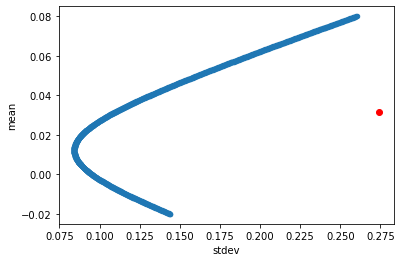

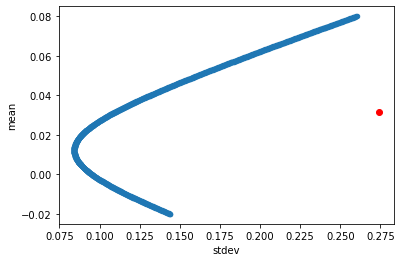

In [59]:
#画出风险资产可行集
plt = frontier.plot(kind='scatter',x='stdev',y='mean')
plt.plot(var,avg,'ro',label="point")

## 对不同风险厌恶系数$\gamma$计算投资者效用

In [60]:
for γ in [0,1,2,3]:
    frontier['utility_γ='+str(γ)] = frontier['mean'] - γ / 2 * frontier['stdev']
frontier = frontier.astype(float)
frontier

,stdev,mean,utility_γ=0,utility_γ=1,utility_γ=2,utility_γ=3
0,0.144008,-0.0200,-0.0200,-0.092004,-0.164008,-0.236012
1,0.143714,-0.0199,-0.0199,-0.091757,-0.163614,-0.235470
2,0.143420,-0.0198,-0.0198,-0.091510,-0.163220,-0.234929
3,0.143126,-0.0197,-0.0197,-0.091263,-0.162826,-0.234389
4,0.142833,-0.0196,-0.0196,-0.091016,-0.162433,-0.233849
...,...,...,...,...,...,...
996,0.258731,0.0796,0.0796,-0.049765,-0.179131,-0.308496
997,0.259074,0.0797,0.0797,-0.049837,-0.179374,-0.308911
998,0.259417,0.0798,0.0798,-0.049909,-0.179617,-0.309326
999,0.259761,0.0799,0.0799,-0.049980,-0.179861,-0.309741


,stdev,mean,utility_γ=0,utility_γ=1,utility_γ=2,utility_γ=3
0,0.144008,-0.0200,-0.0200,-0.092004,-0.164008,-0.236012
1,0.143714,-0.0199,-0.0199,-0.091757,-0.163614,-0.235470
2,0.143420,-0.0198,-0.0198,-0.091510,-0.163220,-0.234929
3,0.143126,-0.0197,-0.0197,-0.091263,-0.162826,-0.234389
4,0.142833,-0.0196,-0.0196,-0.091016,-0.162433,-0.233849
...,...,...,...,...,...,...
996,0.258731,0.0796,0.0796,-0.049765,-0.179131,-0.308496
997,0.259074,0.0797,0.0797,-0.049837,-0.179374,-0.308911
998,0.259417,0.0798,0.0798,-0.049909,-0.179617,-0.309326
999,0.259761,0.0799,0.0799,-0.049980,-0.179861,-0.309741


In [61]:
frontier.idxmax()

stdev          1000
mean           1000
utility_γ=0    1000
utility_γ=1     475
utility_γ=2     388
utility_γ=3     365
dtype: int64

stdev          1000
mean           1000
utility_γ=0    1000
utility_γ=1     475
utility_γ=2     388
utility_γ=3     365
dtype: int64

# Part V: Black-Litterman 模型

In [62]:
import pandas as pd
import numpy as np
from numpy.linalg import inv
import datetime
from datetime import timedelta

读取数据和初始数据处理:
初始数据：每日收盘价、每日预测价格、市值在同一张表格上，其中股票代码_close是收盘价，股票代码_predict是分析师预测价，股票代码_value是总市值

In [63]:
#读取数据和初始数据处理
homepath='data/stocks.csv'
asset_price=pd.read_csv(homepath,index_col='date',parse_dates=True)
asset_price.head()

,000100_close,000100_predict,000002_close,000002_predict,600703_close,600703_predict,000708_close,000708_predict,601390_close,601390_predict,...,600111_return,600011_return,600406_return,002236_return,600809_return,600346_return,000651_return,002241_return,000977_return,600893_return
date,,,,,,,,,,,,,,,,,,,,,
2010-01-04,5.19,NaN,10.60,15.5071,58.03,44.9033,12.11,NaN,6.23,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-05,5.35,NaN,10.36,15.5071,57.79,44.9033,12.50,NaN,6.24,NaN,...,0.016009,0.009988,-0.022917,-0.028129,0.001180,0.037037,-0.029119,0.016371,0.044747,0.030740
2010-01-06,5.23,NaN,10.36,15.5071,59.89,44.9033,12.33,NaN,6.19,NaN,...,-0.011204,-0.006180,0.002559,-0.000402,-0.017672,-0.019048,-0.021580,0.024497,-0.018622,0.023932
2010-01-07,5.19,NaN,10.28,12.4000,62.99,44.9033,11.89,NaN,6.10,NaN,...,-0.028329,-0.022388,-0.032327,-0.032708,-0.049652,-0.042476,-0.042991,-0.025549,0.011385,0.009709
2010-01-08,5.28,NaN,10.35,12.4000,62.99,44.9033,12.09,NaN,6.13,NaN,...,-0.011297,0.000000,0.026813,0.007483,-0.020949,0.007605,0.023047,0.011765,0.100375,0.003205


,000100_close,000100_predict,000002_close,000002_predict,600703_close,600703_predict,000708_close,000708_predict,601390_close,601390_predict,...,600111_return,600011_return,600406_return,002236_return,600809_return,600346_return,000651_return,002241_return,000977_return,600893_return
date,,,,,,,,,,,,,,,,,,,,,
2010-01-04,5.19,NaN,10.60,15.5071,58.03,44.9033,12.11,NaN,6.23,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-05,5.35,NaN,10.36,15.5071,57.79,44.9033,12.50,NaN,6.24,NaN,...,0.016009,0.009988,-0.022917,-0.028129,0.001180,0.037037,-0.029119,0.016371,0.044747,0.030740
2010-01-06,5.23,NaN,10.36,15.5071,59.89,44.9033,12.33,NaN,6.19,NaN,...,-0.011204,-0.006180,0.002559,-0.000402,-0.017672,-0.019048,-0.021580,0.024497,-0.018622,0.023932
2010-01-07,5.19,NaN,10.28,12.4000,62.99,44.9033,11.89,NaN,6.10,NaN,...,-0.028329,-0.022388,-0.032327,-0.032708,-0.049652,-0.042476,-0.042991,-0.025549,0.011385,0.009709
2010-01-08,5.28,NaN,10.35,12.4000,62.99,44.9033,12.09,NaN,6.13,NaN,...,-0.011297,0.000000,0.026813,0.007483,-0.020949,0.007605,0.023047,0.011765,0.100375,0.003205


分成每日收盘价、每日预测价格、市值三张表，把列名变成股票代码，并计算每日收益率r、每日专家预测涨跌v、权重m。
为了方便后续计算，对齐列名

In [64]:
#分成每日收盘价、每日预测价格、市值三张表
cols=asset_price.columns
cols_predict=cols[cols.str.contains('predict')]
cols_value=cols[cols.str.contains('value')]
cols_close=cols[cols.str.contains('close')]

asset_close=asset_price[cols_close]
asset_predict=asset_price[cols_predict]
asset_value=asset_price[cols_value]

#把列名变成股票代码
asset_close.columns=[x[0:6] for x in asset_close.columns]
asset_predict.columns=[x[0:6] for x in asset_predict.columns]
asset_value.columns=[x[0:6] for x in asset_value.columns]

#计算每日收益率r、每日专家预测涨跌v、权重m
asset_r=(asset_close/asset_close.shift(1)-1-0.0001).dropna()
asset_v=(asset_predict/asset_close-1)/250
asset_m=asset_value.apply(lambda x :x/x.sum(),axis=1)

#对齐列名
asset_v=asset_v.sort_index(axis=1)
asset_m=asset_m.sort_index(axis=1)
asset_r=asset_r.sort_index(axis=1)


In [65]:
asset_v.tail()

,000002,000100,000651,000708,000977,002236,002241,300035,600011,600111,600346,600406,600703,600809,600893,601318,601390,601668,601857
date,,,,,,,,,,,,,,,,,,,
2021-09-24,0.002409,0.003068,0.002236,0.002876,0.002093,0.001807,0.000846,-0.000744,-0.001612,0.001036,0.002451,0.000374,0.001656,0.000353,0.001798,0.002665,0.000847,0.001940,0.000213
2021-09-27,0.002656,0.002834,0.002150,0.003082,0.002118,0.001885,0.001323,-0.000394,-0.001507,0.001595,0.002524,0.000419,0.001461,0.000310,0.001759,0.002341,0.001035,0.002035,0.000360
2021-09-28,0.002091,0.003003,0.002203,0.003354,0.002044,0.002221,0.001699,-0.000171,-0.001583,0.001586,0.002521,0.000275,0.001440,0.000353,0.001551,0.002307,0.000883,0.001914,0.000172
2021-09-29,0.001416,0.003283,0.002015,0.003665,0.001713,0.002122,0.001837,0.000136,-0.001485,0.001966,0.002898,0.000419,0.001534,0.000340,0.001684,0.002493,0.000970,0.002473,0.000483
2021-09-30,0.001361,0.003260,0.002101,0.003605,0.001711,0.002033,0.001729,-0.000275,-0.001597,0.001586,0.002639,0.000259,0.001620,0.000374,0.001715,0.002604,0.001233,0.002500,0.000505


,000002,000100,000651,000708,000977,002236,002241,300035,600011,600111,600346,600406,600703,600809,600893,601318,601390,601668,601857
date,,,,,,,,,,,,,,,,,,,
2021-09-24,0.002409,0.003068,0.002236,0.002876,0.002093,0.001807,0.000846,-0.000744,-0.001612,0.001036,0.002451,0.000374,0.001656,0.000353,0.001798,0.002665,0.000847,0.001940,0.000213
2021-09-27,0.002656,0.002834,0.002150,0.003082,0.002118,0.001885,0.001323,-0.000394,-0.001507,0.001595,0.002524,0.000419,0.001461,0.000310,0.001759,0.002341,0.001035,0.002035,0.000360
2021-09-28,0.002091,0.003003,0.002203,0.003354,0.002044,0.002221,0.001699,-0.000171,-0.001583,0.001586,0.002521,0.000275,0.001440,0.000353,0.001551,0.002307,0.000883,0.001914,0.000172
2021-09-29,0.001416,0.003283,0.002015,0.003665,0.001713,0.002122,0.001837,0.000136,-0.001485,0.001966,0.002898,0.000419,0.001534,0.000340,0.001684,0.002493,0.000970,0.002473,0.000483
2021-09-30,0.001361,0.003260,0.002101,0.003605,0.001711,0.002033,0.001729,-0.000275,-0.001597,0.001586,0.002639,0.000259,0.001620,0.000374,0.001715,0.002604,0.001233,0.002500,0.000505


In [66]:
asset_m.tail()

,000002,000100,000651,000708,000977,002236,002241,300035,600011,600111,600346,600406,600703,600809,600893,601318,601390,601668,601857
date,,,,,,,,,,,,,,,,,,,
2021-09-24,0.050789,0.019397,0.049032,0.023862,0.009280,0.015502,0.032722,0.004785,0.028081,0.038360,0.040635,0.041196,0.031405,0.084392,0.030873,0.188966,0.031432,0.044373,0.234917
2021-09-27,0.049275,0.019963,0.049477,0.023056,0.009197,0.015274,0.032016,0.004301,0.026769,0.034358,0.039987,0.040581,0.032365,0.084817,0.030325,0.191652,0.029966,0.043440,0.243180
2021-09-28,0.051652,0.019192,0.048321,0.022552,0.009171,0.014717,0.031193,0.004186,0.027197,0.033899,0.039331,0.041320,0.032005,0.081520,0.030867,0.189794,0.029674,0.043057,0.250352
2021-09-29,0.053433,0.019008,0.051329,0.022289,0.008998,0.015102,0.031375,0.003993,0.026925,0.032695,0.038299,0.041179,0.031296,0.084239,0.030673,0.195229,0.030034,0.043898,0.240006
2021-09-30,0.053649,0.019021,0.050482,0.022406,0.008979,0.015388,0.031887,0.004246,0.028114,0.034830,0.039695,0.043127,0.030740,0.083363,0.030704,0.191444,0.030117,0.043604,0.238204


,000002,000100,000651,000708,000977,002236,002241,300035,600011,600111,600346,600406,600703,600809,600893,601318,601390,601668,601857
date,,,,,,,,,,,,,,,,,,,
2021-09-24,0.050789,0.019397,0.049032,0.023862,0.009280,0.015502,0.032722,0.004785,0.028081,0.038360,0.040635,0.041196,0.031405,0.084392,0.030873,0.188966,0.031432,0.044373,0.234917
2021-09-27,0.049275,0.019963,0.049477,0.023056,0.009197,0.015274,0.032016,0.004301,0.026769,0.034358,0.039987,0.040581,0.032365,0.084817,0.030325,0.191652,0.029966,0.043440,0.243180
2021-09-28,0.051652,0.019192,0.048321,0.022552,0.009171,0.014717,0.031193,0.004186,0.027197,0.033899,0.039331,0.041320,0.032005,0.081520,0.030867,0.189794,0.029674,0.043057,0.250352
2021-09-29,0.053433,0.019008,0.051329,0.022289,0.008998,0.015102,0.031375,0.003993,0.026925,0.032695,0.038299,0.041179,0.031296,0.084239,0.030673,0.195229,0.030034,0.043898,0.240006
2021-09-30,0.053649,0.019021,0.050482,0.022406,0.008979,0.015388,0.031887,0.004246,0.028114,0.034830,0.039695,0.043127,0.030740,0.083363,0.030704,0.191444,0.030117,0.043604,0.238204


In [67]:
asset_r.tail()

,000002,000100,000651,000708,000977,002236,002241,300035,600011,600111,600346,600406,600703,600809,600893,601318,601390,601668,601857
date,,,,,,,,,,,,,,,,,,,
2021-09-24,-0.011292,-0.019917,-0.005348,-0.044013,0.000237,-0.003413,-0.022912,-0.027332,0.033440,-0.036214,-0.046620,-0.022454,-0.011918,0.031319,-0.022068,-0.003003,-0.035756,-0.025843,-0.003439
2021-09-27,-0.025198,0.034115,0.013880,-0.029204,-0.004142,-0.010071,-0.016935,-0.097070,-0.042167,-0.100080,-0.011273,-0.010230,0.035472,0.009816,-0.013094,0.019035,-0.042117,-0.016360,0.040101
2021-09-28,0.064009,-0.024160,-0.008685,-0.007126,0.012075,-0.021921,-0.011059,-0.011925,0.031268,0.001484,-0.001607,0.033526,0.003750,-0.024415,0.033189,0.005206,0.005163,0.006098,0.044989
2021-09-29,0.004169,-0.038621,0.031125,-0.040666,-0.047544,-0.003961,-0.023646,-0.074162,-0.039029,-0.063800,-0.054796,-0.032632,-0.050837,0.003055,-0.035411,-0.001521,-0.017552,-0.010367,-0.069437
2021-09-30,0.006513,0.003105,-0.014095,0.007766,0.000251,0.021433,0.018813,0.065915,0.046735,0.067934,0.039006,0.049900,-0.015327,-0.007962,0.003485,-0.016973,0.005229,-0.004249,-0.005067


,000002,000100,000651,000708,000977,002236,002241,300035,600011,600111,600346,600406,600703,600809,600893,601318,601390,601668,601857
date,,,,,,,,,,,,,,,,,,,
2021-09-24,-0.011292,-0.019917,-0.005348,-0.044013,0.000237,-0.003413,-0.022912,-0.027332,0.033440,-0.036214,-0.046620,-0.022454,-0.011918,0.031319,-0.022068,-0.003003,-0.035756,-0.025843,-0.003439
2021-09-27,-0.025198,0.034115,0.013880,-0.029204,-0.004142,-0.010071,-0.016935,-0.097070,-0.042167,-0.100080,-0.011273,-0.010230,0.035472,0.009816,-0.013094,0.019035,-0.042117,-0.016360,0.040101
2021-09-28,0.064009,-0.024160,-0.008685,-0.007126,0.012075,-0.021921,-0.011059,-0.011925,0.031268,0.001484,-0.001607,0.033526,0.003750,-0.024415,0.033189,0.005206,0.005163,0.006098,0.044989
2021-09-29,0.004169,-0.038621,0.031125,-0.040666,-0.047544,-0.003961,-0.023646,-0.074162,-0.039029,-0.063800,-0.054796,-0.032632,-0.050837,0.003055,-0.035411,-0.001521,-0.017552,-0.010367,-0.069437
2021-09-30,0.006513,0.003105,-0.014095,0.007766,0.000251,0.021433,0.018813,0.065915,0.046735,0.067934,0.039006,0.049900,-0.015327,-0.007962,0.003485,-0.016973,0.005229,-0.004249,-0.005067


首先，截取数据，每20天算一次权重，每次计算权重使用过去一年的数据计算方差，用最新一条分析师预测价得出的预期收益率矩阵来生成观点矩阵，如果没有观点数据则使用隐含收益率作为观点收益率，考虑到预期收益率在实现时长上有较大的不确定性，在本模型中仅仅采取预期收益率的多空信息，如果看多，则视作有一条该股票预期日收益率会是当前日收益率加上一个日收益率的标准差的观点，看空则视作有一条该股票预期日收益率会是当前日收益率减去一个日收益率的标准差的观点。

其次，使用bl模型的公式，分别计算出隐含收益率、后验收益率和权重。

计算隐含收益率的公式：

$$
\Pi=\lambda \Sigma w_{m k t}
$$
where

$\Pi$  is the Implied Excess Equilibrium Return Vector ( $N \times I$ column vector);

$\lambda$  is the risk aversion coefficient;

$\Sigma$  is the covariance matrix of excess returns $(N x N$ matrix $)$;and,

$w_{m t t}$  is the market capitalization weight $\left(N x I\right.$ column vector) of the assets.

计算后验收益率的公式如下。注意因为最终只需要得到权重，简单mvo下，权重与后验收益率成比例，所以计算后验收益率的时候保证相对比例正确即可，可以不用乘以它们共同的系数。

$$
E[R]=\left[(\tau \Sigma)^{-1}+P^{\prime} \Omega^{-1} P\right]^{-1}\left[(\tau \Sigma)^{-1} \Pi+P^{\prime} \Omega^{-1} Q\right]
$$
where

$E[R]$ is the new (posterior) Combined Return Vector $(N \times I$ column vector);

$\tau$  is a scalar;

$\Sigma$  is the covariance matrix of excess returns ( $N \times N$ matrix);

$P$  is a matrix that identifies the assets involved in the views $(K \times N$ matrix or $1 \times N$ row vector in the special case of 1 view);

$\Omega$  is a diagonal covariance matrix of error terms from the expressed views representing the uncertainty in each view ( $K \times K$ matrix);

$\Pi$  is the Implied Equilibrium Return Vector ( $N \times I$ column vector); and, $Q$  is the View Vector $(K \times l$ column vector).

计算最终权重的公式（简单MVO的一阶条件）如下。注意最终需要标准化。

$$
w=(\lambda \Sigma)^{-1} \mu
$$

In [68]:
nowdate=datetime.date(2012,9,30)
dtime=timedelta(days=365)
ddtime=timedelta(days=20)
enddate=pd.Timestamp('2021-09-30')
blindex=[]
bl_result=pd.DataFrame(columns=asset_r.columns)

for j in range(200):
    nowdate=pd.Timestamp(nowdate)
 
    #读该段时间内的数据
    asset_returns=asset_r.loc[nowdate-dtime:nowdate].dropna()
    asset_weights=asset_m.loc[nowdate-ddtime:nowdate]
    asset_weights=asset_weights.iloc[-1]
    asset_view=asset_v.loc[nowdate-ddtime:nowdate]
    asset_view=asset_view.iloc[-1]
    latest_return=asset_returns.iloc[-1]
    
    #计算协方差矩阵，设定风险厌恶系数为3
    asset_cov = asset_returns.cov()
    risk_aversion = 3

    #用risk aversion、协方差矩阵和权重算市场隐含收益率
    implied_rets = risk_aversion * asset_cov.dot(asset_weights).squeeze()#squeeze是移除数组中维度为1的维度,套公式算出市场隐含的收益率

    #把asset_view变成P、Q矩阵的形式
    p=np.zeros((len(asset_close.columns),len(asset_close.columns)))
    q=np.zeros(len(asset_close.columns))
    for i in range(len(asset_close.columns)):
        p[i][i]=1
        if not pd.isnull(asset_view.iloc[i]) :
            if asset_view.iloc[i]>0:
                q[i]=latest_return[i]+asset_cov.iloc[i][i]**0.5
            else:
                q[i]=latest_return[i]-asset_cov.iloc[i][i]**0.5
        else:
            q[i]=implied_rets[i]

    #计算view的方差
    tau = 0.025
    omega = np.diag(np.diag(p.dot(tau * asset_cov).dot(p.T)))

    #sigma的方差
    sigma_scaled =asset_cov * tau

    #计算BL模型的后验收益率(只需要比例正确)
    BL_return_vector = implied_rets + sigma_scaled.dot(p.T).dot(inv(p.dot(sigma_scaled).dot(p.T) + omega).dot(q - p.dot(implied_rets)))

    #计算权重,因为是权重，所以只需要比例，不需要除以风险厌恶系数
    inverse_cov = pd.DataFrame(inv(asset_cov.values), index=asset_cov.columns, columns=asset_cov.index)
    BL_weights_vector = inverse_cov.dot(BL_return_vector)
    BL_weights_vector = BL_weights_vector/sum(BL_weights_vector)
    bl_result=bl_result.append(BL_weights_vector,ignore_index=True)
    blindex.append(nowdate)
    nowdate=nowdate+ddtime
    if nowdate>enddate:
        break
bl_result['date']=blindex
bl_result=bl_result.set_index('date')
bl_result.to_csv('data/bl_result.csv', index=True, header=True )

# Part VI: 回测函数实现

将最新的资产回报率数据导入回测系统，一次性输入资产配置策略组合各个部分的权重
和配置时间，选出portfolio，逐行扫描策略组合每个时间点的资产配置权重，
通过矩阵乘法得到回报率曲线和baseline。

In [69]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [70]:
class Backtester:
    def __init__(self,name):
        self.asset_pct = None
        self.portfolio = None
        self.portfolio_name=name

        self.return_curve = pd.DataFrame({'date': []})
        self.baseline = pd.DataFrame({'date': []})

    #更新回测所用的数据
    def update_data(self,asset_path):
        #读取回测数据
        self.asset_pct = pd.read_csv(asset_path)
        self.asset_pct['date'] = self.asset_pct['date'].astype("str")
        self.asset_pct['date'] = pd.to_datetime(self.asset_pct['date'], errors='coerce')

        stock_list = self.asset_pct.columns[self.asset_pct.columns.str.contains('stock')].tolist()
        for stock in stock_list:
            self.asset_pct = self.asset_pct.rename(columns={stock:stock[6:]})

    def init_portfolio(self,strategy_path):
        strategy = pd.read_csv(strategy_path)
        strategy['date'] = strategy['date'].astype("str")
        strategy['date'] = pd.to_datetime(strategy['date'], errors='coerce')

        portfolio_list = strategy.columns.tolist()[1:]
        self.portfolio = self.asset_pct.loc[self.asset_pct['date']>=strategy.iloc[0,0],['date']+portfolio_list].reset_index(drop = True)
        self.portfolio.iloc[0,1:] = 0
        self.portfolio.iloc[:,1:] /= 100
        self.portfolio.iloc[:,1:] += 1
        self.portfolio.iloc[:,1:] = self.portfolio.iloc[:,1:].cumprod(axis=0)
        #生成投资组合的回报率曲线
        self.return_curve['date'] = self.portfolio['date']
        for i in range(strategy.shape[0]):
            self.return_curve.loc[i:,'value'] = np.dot(self.portfolio.iloc[i:,1:],strategy.iloc[i,1:])
        #生成baseline
        equal_weight = strategy.iloc[0,1:]
        equal_weight[:] = 1/(equal_weight.shape[0])
        self.baseline['date'] = self.portfolio['date']
        self.baseline['value'] = np.dot(self.portfolio.iloc[:,1:],equal_weight)

    def get_portfolio_return(self,start_date):
        return self.return_curve.loc[self.return_curve['date']>=start_date,:]

    def _cal_sharpe_ratio(self,asset,start_date):
        portfolio_return = (asset.loc[asset['date']>=start_date,'value']/(asset.loc[asset['date']>=start_date,'value'].shift(1)))-1

        return_mean = np.mean(portfolio_return)
        return_std = np.std(portfolio_return)
        year_sharpe_ratio = return_mean/return_std*np.sqrt(250)
        return year_sharpe_ratio

    def _cal_bl_sharpe_ratio(self,asset,start_date):
        portfolio_return = (asset.loc[asset['date']>=start_date,'value']/(asset.loc[asset['date']>=start_date,'value'].shift(1)))-1

        return_mean = np.mean(portfolio_return)
        return_std = np.std(portfolio_return)
        year_sharpe_ratio = (return_mean-1e-4)/return_std*np.sqrt(250)
        return year_sharpe_ratio

    def draw_return(self,start_date,bl=False):
        show_data = self.return_curve.loc[self.return_curve['date']>=start_date,:]
        return_show = show_data.copy()
        return_show.iloc[:,1] = show_data.iloc[:, 1] / show_data.iloc[0, 1]

        base = self.baseline.loc[self.return_curve['date']>=start_date,:]
        base_show = base.copy()
        base_show.iloc[:, 1] = base.iloc[:,1] / base.iloc[0,1]
        
        plt.figure(figsize=(12,6))
        plt.plot(return_show.iloc[:,0],return_show.iloc[:,1])
        plt.plot(base_show.iloc[:, 0], base_show.iloc[:,1])

        plt.legend([self.portfolio_name,'baseline'])
        plt.xlabel('year')
        plt.ylabel('return')

        if(bl==True):
            print("sharpe ratio of portfolio is:", self._cal_bl_sharpe_ratio(self.return_curve,start_date))
            print("sharpe ratio of baseline is:", self._cal_bl_sharpe_ratio(self.baseline,start_date))
        else:
            print("sharpe ratio of portfolio is:", self._cal_sharpe_ratio(self.return_curve, start_date))
            print("sharpe ratio of baseline is:", self._cal_sharpe_ratio(self.baseline, start_date))


# Part VII: 回测结果

## Risk Parity 回测

sharpe ratio of portfolio is: 0.541605264222506
sharpe ratio of baseline is: 0.4456219076144727


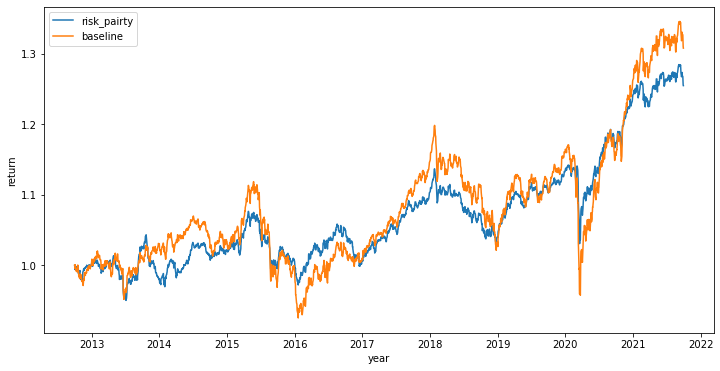

sharpe ratio of portfolio is: 1.4168280822494579
sharpe ratio of baseline is: 1.717707884008738


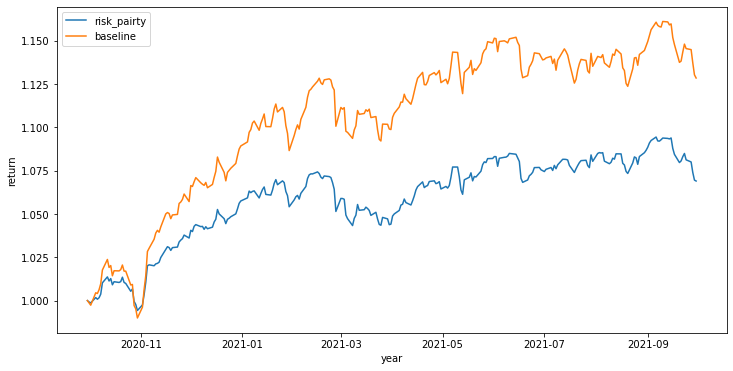

sharpe ratio of portfolio is: 0.541605264222506
sharpe ratio of baseline is: 0.4456219076144727


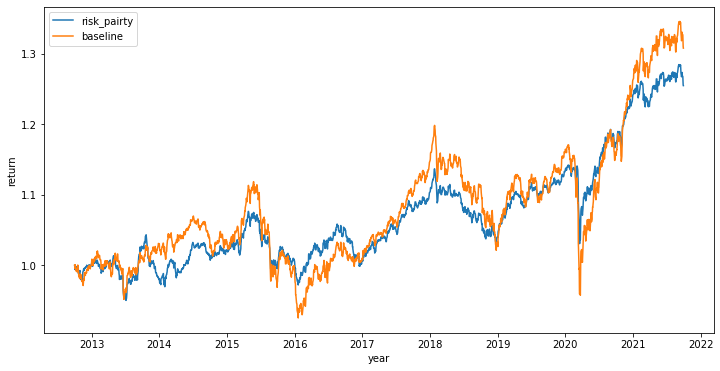

sharpe ratio of portfolio is: 1.4168280822494579
sharpe ratio of baseline is: 1.717707884008738


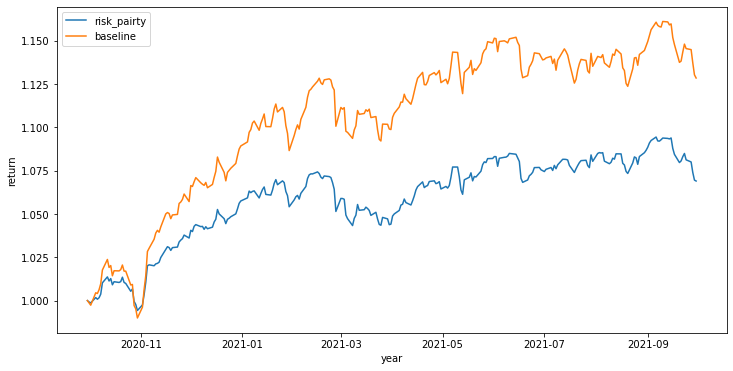

In [71]:
bt_risk_pairty = Backtester('risk_pairty')
bt_risk_pairty.update_data("data/pct_table.csv")
bt_risk_pairty.init_portfolio("data/RiskPairty_weight_for_test.csv")
#print(bt_risk_pairty.return_curve)

bt_risk_pairty.draw_return(pd.to_datetime('20120930'))
plt.show()
bt_risk_pairty.draw_return(pd.to_datetime('20200930'))
plt.show()

## Risk Budget 回测

sharpe ratio of portfolio is: 0.45981050496926
sharpe ratio of baseline is: 0.4456219076144727


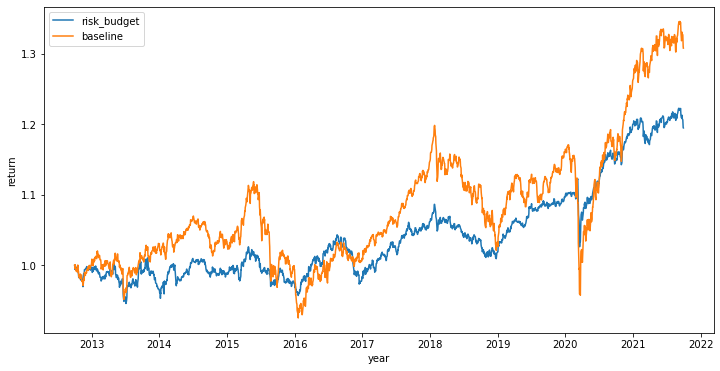

sharpe ratio of portfolio is: 0.9450523719792308
sharpe ratio of baseline is: 1.717707884008738


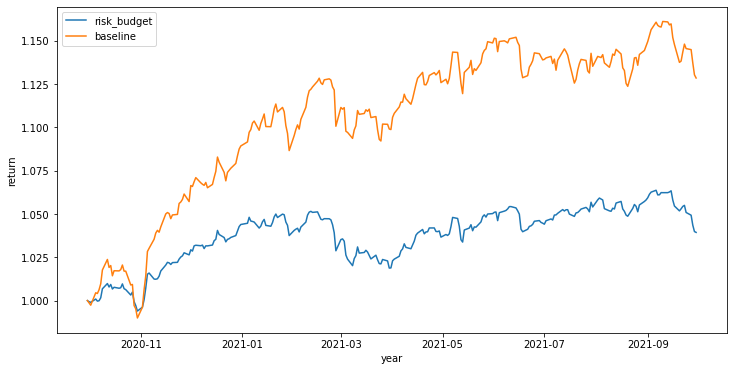

sharpe ratio of portfolio is: 0.45981050496926
sharpe ratio of baseline is: 0.4456219076144727


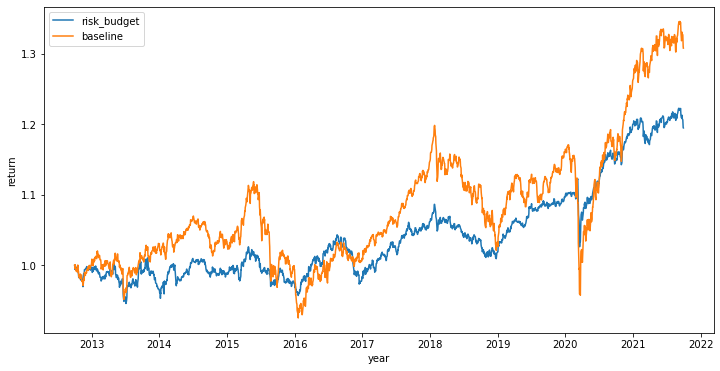

sharpe ratio of portfolio is: 0.9450523719792308
sharpe ratio of baseline is: 1.717707884008738


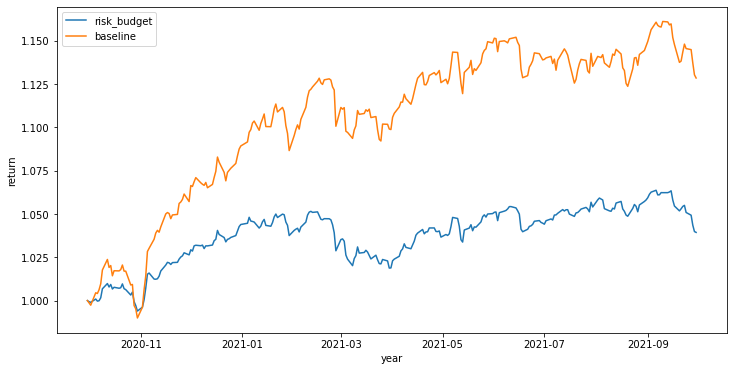

In [72]:
bt_risk_budget = Backtester('risk_budget')
bt_risk_budget.update_data("data/pct_table.csv")
bt_risk_budget.init_portfolio("data/RiskBudget_weight_for_test.csv")
#print(bt_risk_budget.return_curve)

bt_risk_budget.draw_return(pd.to_datetime('20120930'))
plt.show()
bt_risk_budget.draw_return(pd.to_datetime('20200930'))
plt.show()

## MVO回测

sharpe ratio of portfolio is: 0.593712661583833
sharpe ratio of baseline is: 0.4456219076144727


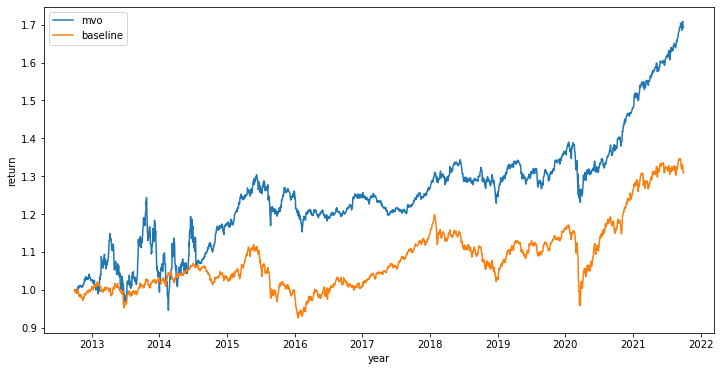

sharpe ratio of portfolio is: 3.927977791959651
sharpe ratio of baseline is: 1.717707884008738


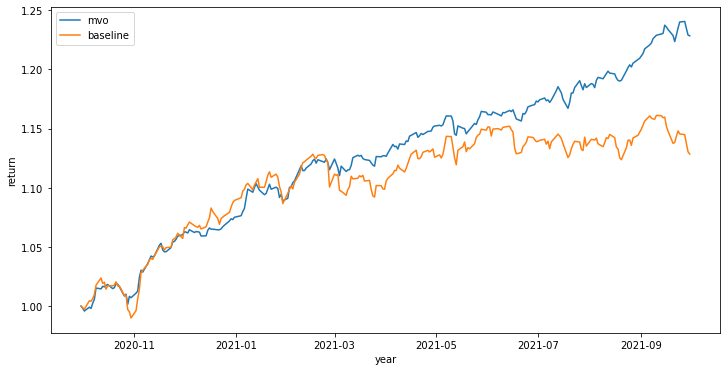

sharpe ratio of portfolio is: 0.593712661583833
sharpe ratio of baseline is: 0.4456219076144727


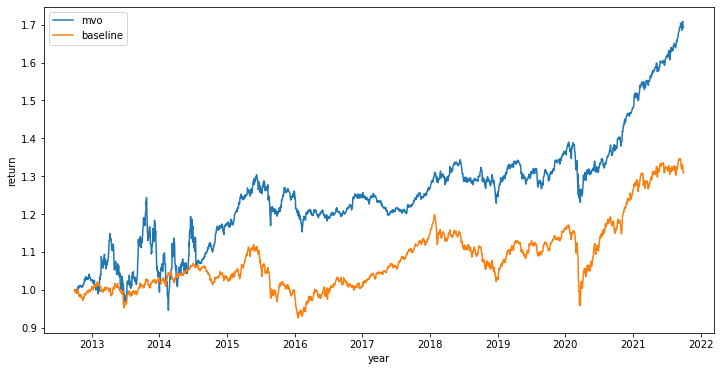

sharpe ratio of portfolio is: 3.927977791959651
sharpe ratio of baseline is: 1.717707884008738


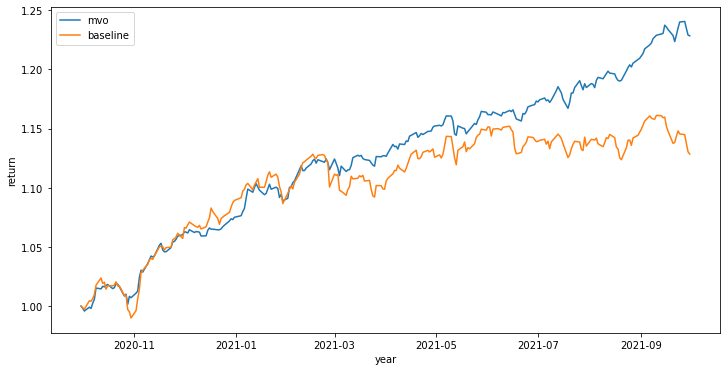

In [73]:
bt_mvo = Backtester('mvo')
bt_mvo.update_data("data/pct_table.csv")
bt_mvo.init_portfolio("data/MVO_weight_for_test.csv")
#print(bt_risk_pairty.return_curve)

bt_mvo.draw_return(pd.to_datetime('20120930'))
plt.show()
bt_mvo.draw_return(pd.to_datetime('20200930'))
plt.show()

## Black-Litterman 回测

sharpe ratio of portfolio is: 0.26196217867276755
sharpe ratio of baseline is: 0.38695313149314103


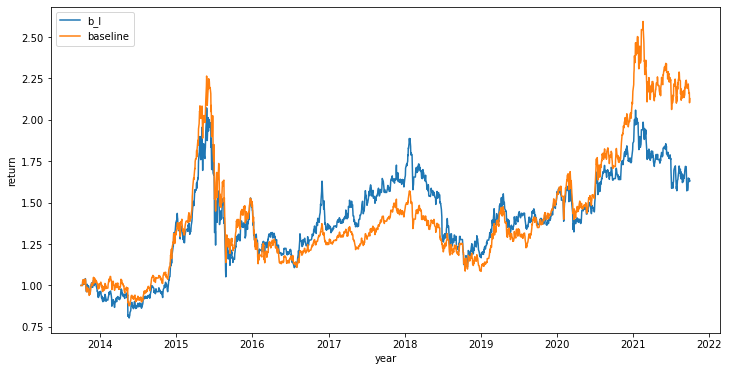

sharpe ratio of portfolio is: -0.02966195225124103
sharpe ratio of baseline is: 0.8571449873641366


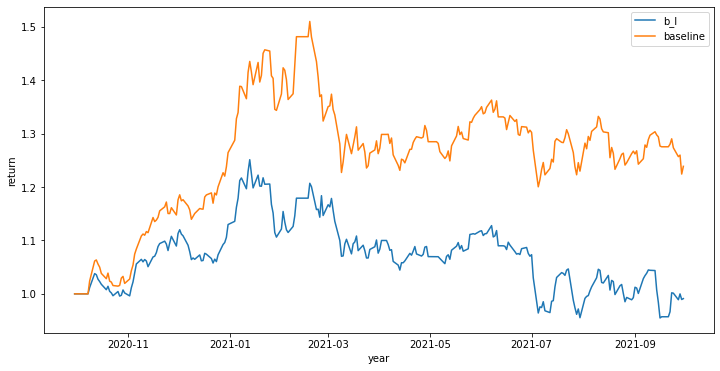

sharpe ratio of portfolio is: 0.26196217867276755
sharpe ratio of baseline is: 0.38695313149314103


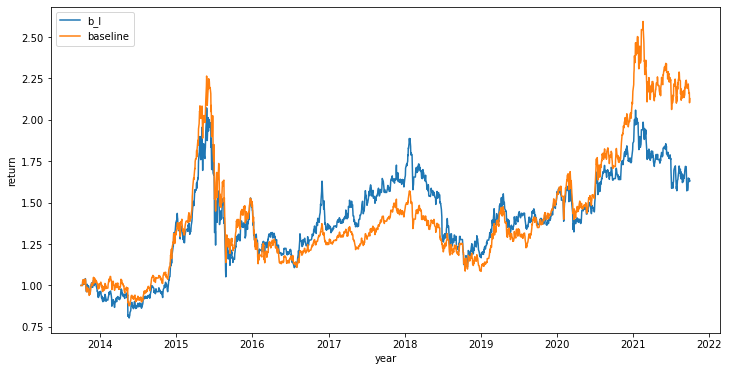

sharpe ratio of portfolio is: -0.02966195225124103
sharpe ratio of baseline is: 0.8571449873641366


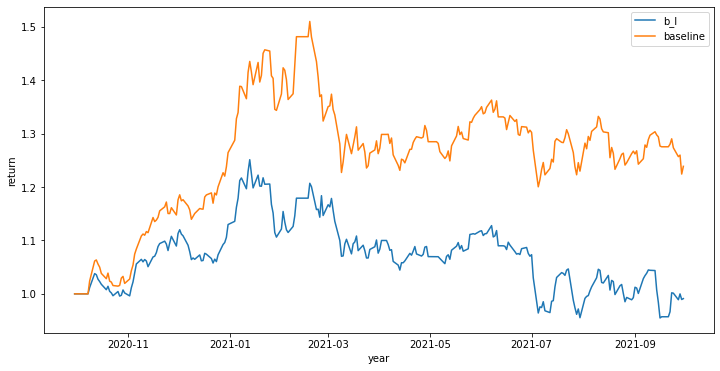

In [74]:
bt_bl = Backtester('b_l')
bt_bl.update_data("data/asset_pct_table.csv")
bt_bl.init_portfolio("data/bl_result.csv")
#print(bt_risk_budget.return_curve)

bt_bl.draw_return(pd.to_datetime('20130930'),True)
plt.show()
bt_bl.draw_return(pd.to_datetime('20200930'),True)
plt.show()